In [38]:
from utils.util import read_dataset

train_data = read_dataset(dirpath="./datasets/it-trajs_complete/train", interpolate=True, normalize=False)

In [59]:
all_label_zeros = []
all_label_ones = []
all_label_twos = []
all_label_threes = []


for filename, dic in train_data.items():
    if filename[0] == '0':
        all_label_zeros.append(dic)
    if filename[0] == '1':
        all_label_ones.append(dic)
    if filename[0] == '2':
        all_label_twos.append(dic)
    if filename[0] == '3':
        all_label_threes.append(dic)


<Axes: xlabel='x'>

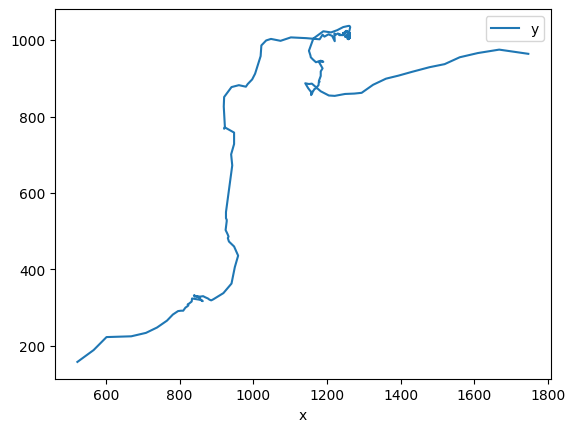

In [60]:
all_label_ones[0]
all_label_ones[0]['dataframe'].plot(x='x', y='y')


In [57]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

def train_hmm_on_label(all_label_ones, n_states=4, cov_type='full', n_iter=100):
    """
    Train a Gaussian HMM on the delta-XY sequences of underrepresented class.
    
    Parameters:
        all_label_ones (list of dict): Each dict has key 'dataframe', a pd.DataFrame with columns ['x', 'y'].
        n_states (int): Number of hidden states in the HMM.
        cov_type (str): Covariance type for the Gaussian emissions.
        n_iter (int): Max iterations for the HMM fitting.
        
    Returns:
        model (GaussianHMM): Fitted HMM.
    """
    sequences = []
    lengths = []
    
    # Build concatenated sequence of step-deltas
    for entry in all_label_ones:
        df = entry['dataframe']
        coords = df[['x', 'y']].values
        # Compute displacements between consecutive frames
        deltas = np.diff(coords, axis=0)
        if len(deltas) < 1:
            continue
        sequences.append(deltas)
        lengths.append(len(deltas))
    
    X = np.vstack(sequences)
    
    # Initialize and fit the HMM
    model = GaussianHMM(n_components=n_states,
                        covariance_type=cov_type,
                        n_iter=n_iter,
                        random_state=42)
    model.fit(X, lengths)
    return model

def generate_synthetic_trajectories(model, all_label_ones, n_samples=50):
    """
    Generate synthetic trajectories using the trained HMM.
    
    Parameters:
        model (GaussianHMM): Trained HMM on delta-XY sequences.
        all_label_ones (list of dict): Original data for sampling start positions.
        n_samples (int): Number of synthetic trajectories to generate.
        
    Returns:
        list of pd.DataFrame: Each DataFrame has columns ['frame', 'x', 'y'].
    """
    synthetic = []
    # Collect original sequence lengths
    orig_lengths = [len(entry['dataframe']) for entry in all_label_ones if len(entry['dataframe']) > 1]
    
    for _ in range(n_samples):
        # Choose a random length from original trajectories
        L = np.random.choice(orig_lengths)
        # We model deltas, so sample one less
        n_steps = max(L - 1, 1)
        
        # Sample deltas from the HMM
        deltas, _ = model.sample(n_steps)
        
        # Pick a random real starting point for realism
        start_df = np.random.choice(all_label_ones)['dataframe']
        start_point = start_df[['x', 'y']].iloc[0].values
        
        # Reconstruct coordinates by cumulative sum of deltas
        coords = np.vstack([start_point, start_point + np.cumsum(deltas, axis=0)])
        
        # Build DataFrame
        frames = np.arange(len(coords))
        df_syn = pd.DataFrame({
            'frame': frames,
            'x': coords[:, 0],
            'y': coords[:, 1]
        })
        synthetic.append(df_syn)
    
    return synthetic


In [61]:

model_one = train_hmm_on_label(all_label_ones, n_states=4)
model_two = train_hmm_on_label(all_label_twos, n_states=4)
model_three = train_hmm_on_label(all_label_threes, n_states=4)
#Now `synthetic_trajs` is a list of DataFrames you can add to your training set.

Model is not converging.  Current: -11499.862231738576 is not greater than -9290.852978701689. Delta is -2209.0092530368875


In [62]:
len_zero = len(all_label_zeros)
len_one = len(all_label_ones)
len_two = len(all_label_twos)
len_three = len(all_label_threes)

In [63]:
synthetic_trajs_one = generate_synthetic_trajectories(model_one, all_label_ones, n_samples=(len_zero-len_one))
synthetic_trajs_two = generate_synthetic_trajectories(model_two, all_label_twos, n_samples=(len_zero-len_two))
synthetic_trajs_three = generate_synthetic_trajectories(model_three, all_label_threes, n_samples=((len_zero-len_three)))

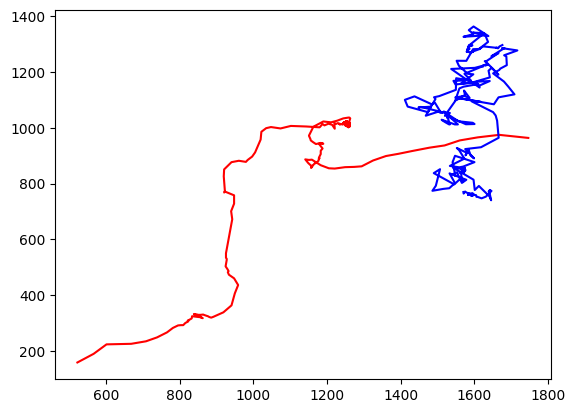

In [67]:
import matplotlib.pyplot as plt
real_df = all_label_ones[0]['dataframe']
synthetic_df = synthetic_trajs_one[4]
plt.plot(real_df['x'], real_df['y'], 'r-', synthetic_df['x'], synthetic_df['y'], 'b-')


In [72]:
import os

def save_trajectories_to_dir(trajectories, output_dir, prefix):
    """
    Save a list of DataFrame trajectories to CSV files in the given directory.
    
    Parameters:
    -----------
    trajectories : list of pd.DataFrame
        Each DataFrame should have columns like ['frame', 'x', 'y'] (or similar).
    output_dir : str
        Path to directory where CSVs will be saved. Will be created if it doesn't exist.
    prefix : str, optional
        Filename prefix for each trajectory. Defaults to 'traj'.
        
    Returns:
    --------
    None
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for idx, df in enumerate(trajectories, start=1):
        df_to_save = df.rename(columns={
            'x': 'x0',
            'y': 'y0',
            'frame': 'nframe'
        })
        filename = f"{prefix}_syn_{idx}.csv"
        path = os.path.join(output_dir, filename)
        df_to_save.to_csv(path, index=False)

In [73]:
save_trajectories_to_dir(synthetic_trajs_one, "datasets/it-trajs_synthetic/train", "1")
save_trajectories_to_dir(synthetic_trajs_two, "datasets/it-trajs_synthetic/train", "2")
save_trajectories_to_dir(synthetic_trajs_three, "datasets/it-trajs_synthetic/train", "3")
